# $\varepsilon$-Greedy方法

## 1. 定义Solver基类

In [1]:
import numpy as np


class Solver:
    def __init__(self, bandit):
        self.bandit = bandit  # 指定多臂老虎机组合
        self.counts = np.zeros(self.bandit.K)  # 每个臂被选择的次数
        self.regret = 0  # 当前步的累计后悔
        self.actions = []
        self.regrets = []

    def update_regret(self, k):
        # 计算当前选择的动作k的遗憾值，遗憾值是指选择最佳动作的概率与实际选择动作的概率之差
        # self.bandit.best_prob 是当前环境下最佳动作的概率
        # self.bandit.probs[k] 是当前选择的动作k的概率
        # 将遗憾值累加到总的遗憾值 self.regret 中
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        # 将当前的遗憾值加入到遗憾值列表 self.regrets 中，用于后续分析
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 抛出未实现异常
        # 这个方法是一个占位符，表示在子类中需要实现具体的功能
        # 当子类没有实现这个方法时，调用这个方法会抛出NotImplementedError异常
        raise NotImplementedError

    def run(self, num_steps):
        for _ in range(num_steps):
            # 运行一定次数,num_steps为总运行次数
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

## 2. 定义$\varepsilon$-greedy算法

算法步骤

    生成一个 [0,1]之间的随机数。

    如果随机数 < ε：
    随机选择一个动作（探索）。

    否则：
    选择当前估计值最高的动作（利用）。

In [2]:
class EpsilonGreedy(Solver):
    """epsilon贪婪算法,继承Solver类"""

    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        # 初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆
        else:
            k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆
        r = self.bandit.step(k)  # 得到本次动作的奖励
        self.estimates[k] += 1.0 / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

## 3. 测试$\varepsilon$-greedy算法


可视化

In [3]:
import matplotlib.pyplot as plt


def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel("Time steps")
    plt.ylabel("Cumulative regrets")
    plt.title("%d-armed bandit" % solvers[0].bandit.K)
    plt.legend()
    plt.show()

10臂老虎机实验

epsilon-贪婪算法的累积懊悔为： 28.489221136817044


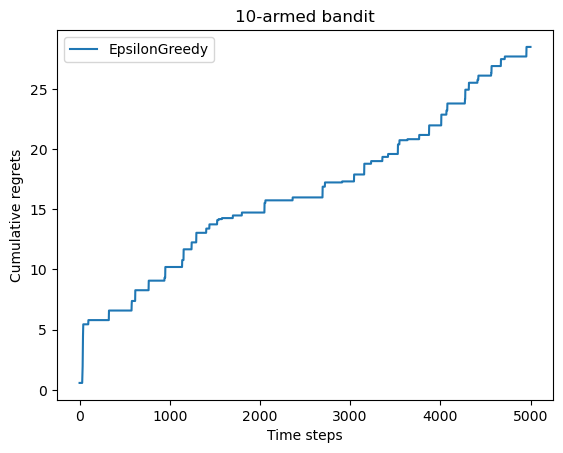

In [4]:
from MAB import BernoulliBandit

np.random.seed(42)
bandit_10_arm = BernoulliBandit(10)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print("epsilon-贪婪算法的累积懊悔为：", epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

调整$\varepsilon$值

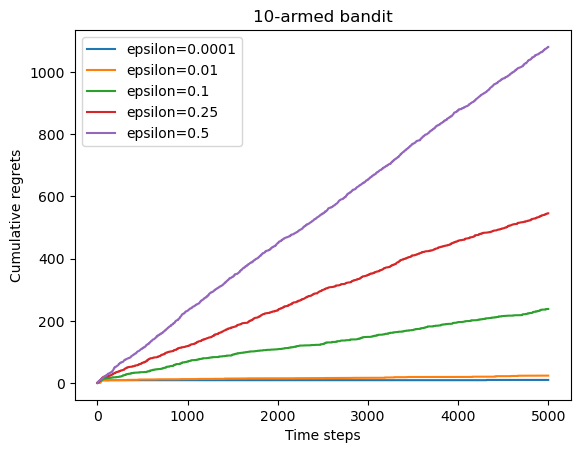

In [5]:
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons]
epsilon_greedy_solver_names = [f"epsilon={e}" for e in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

## 4. $\varepsilon$值衰减的贪心算法